# Semi-Supervised Learning on Graphs

This framework is used to evaluate the method, which is described in detail in "semi-supervided_framework.ipynb".
It allows to easily the resulting testing accuries using different model parameters.

## 1. Import Libraries

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm
# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import pygsp

%matplotlib inline

plt.rcParams['figure.figsize'] = (17, 5)
pygsp.plotting.BACKEND = 'matplotlib'

2018-01-12 11:23:25,999:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



## 2. Choose parameters to use

In [2]:
# Choose the pickle file containing the features and data
feature_file = './Features Data/cut_mfccs_raw_10_1028_20.pickle'

# How many neighbours?
NEIGHBORS = 400

# Define which percentage of known labels should be tested
perc_vec = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95])

# Define how many tries (random mask!) 
N_avg  = 10

## 3. Evaluate

Load the feature matrix fom a .pickle file. To create a pickle file from the raw audio data we can use the test_featur python notebook. To Check the content we display the head of the panda data frame.

In [3]:
# Functions
def prepare_observations(Y, perc):
    """Prepare observations, where p is the percentage of values to keep."""
    M = np.array(np.random.random_sample(np.shape(Y))>(1-perc),dtype = 'int64')
    Y_compr = Y*M
    return Y_compr, M

def solve(Y_compr, M, L, alpha, beta):
    X = np.ones(Y_compr.shape)
    for i in range(Y_compr.shape[0]):
        Mask = np.diag(M[i,:])
        y_i_compr = Y_compr[i,:]
        X[i,:] = np.linalg.solve((Mask+alpha*L+beta),y_i_compr)
        
    return X

def adapt_labels(x_hat):
    # Real accuracy considering only the main words :
    class_names_list = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    mask_names_main = [True if name in class_names_list else False for name in class_names]
    index_names_main = [i for i in range(len(mask_names_main)) if mask_names_main[i] == True]
    inverted_index_names = dict(zip(index_names_main,range(len(index_names_main))))

    # Creating the label names :
    class_names_main = class_names[mask_names_main].tolist()
    class_names_main.extend(["unknown"])

    # Adapting the labels in the test and prediction sets :
    return np.array([inverted_index_names[int(x_hat[i])] if x_hat[i] in index_names_main else len(class_names_main)-1 for i in range(len(x_hat)) ])

# Load features
features_og = pd.read_pickle(feature_file)

# Normalize Features
features = features_og['mfcc']
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

# Sparsify using k-nearest neighbours
for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0
    
# Initialize Graph using the weights matrix
G = pygsp.graphs.Graph(weights)

# Compute the normalized Graph Laplacian corresponding to the above constructed graph
G.compute_laplacian('normalized')

# Build Label vector
# Define class name vector, the index will correspond to the calss label
class_names = features_og['info']['word'].unique()
y = np.ones(len(features_og))
for i in range(0,len(class_names)):
    y +=(features_og['info','word'] == class_names[i]) * i
    
# From feature label to feature matrix
Y = np.zeros((int(np.max(y)),len(y)))
                 
for i in range(np.shape(Y)[0]):
    Y[i,:] = np.array(y == i+1, dtype = 'int64')
    
# Evaluate
pred_vec = np.zeros((N_avg,len(perc_vec)))
for i in range(len(perc_vec)):
    print('-------------------------------------------------------------')
    print('Start evluating p = {} %'.format(perc_vec[i]*100))
    for j in tqdm(range(N_avg), total = N_avg, unit = 'waves'):
         # Set Up
        Y_compr, M = prepare_observations(Y, perc_vec[i])
        y_compr  = np.zeros(y.shape)
        for k in range(Y.shape[0]):
            y_compr += Y_compr[k,:]*(k+1)
        
        # Solve
        X = solve(Y_compr, M, G.L, alpha = 1e-3, beta = 1e-7)

        # Make label vector
        x_hat = np.argmax(X,axis = 0)+np.ones(X[0,:].shape)

        # Unify labels 13-30
        x_hat_adapted = adapt_labels(x_hat)
        y_adapted = adapt_labels(y)

        # Only consider unknowns
        M_inv = np.array(np.sum(Y_compr,axis = 0)==0,dtype = 'int64')
        pred_vec[j,i] = np.sum(x_hat_adapted[M_inv==1]==y_adapted[M_inv==1])/x_hat_adapted[M_inv==1].shape[0]

-------------------------------------------------------------
Start evluating p = 10.0 %


100%|██████████| 10/10 [03:46<00:00, 22.60s/waves]


-------------------------------------------------------------
Start evluating p = 20.0 %


100%|██████████| 10/10 [03:54<00:00, 23.49s/waves]


-------------------------------------------------------------
Start evluating p = 30.0 %


100%|██████████| 10/10 [03:58<00:00, 23.88s/waves]


-------------------------------------------------------------
Start evluating p = 40.0 %


100%|██████████| 10/10 [03:58<00:00, 23.88s/waves]


-------------------------------------------------------------
Start evluating p = 50.0 %


100%|██████████| 10/10 [03:59<00:00, 23.99s/waves]


-------------------------------------------------------------
Start evluating p = 60.0 %


100%|██████████| 10/10 [03:58<00:00, 23.88s/waves]


-------------------------------------------------------------
Start evluating p = 70.0 %


100%|██████████| 10/10 [04:00<00:00, 24.01s/waves]


-------------------------------------------------------------
Start evluating p = 80.0 %


100%|██████████| 10/10 [04:03<00:00, 24.31s/waves]


-------------------------------------------------------------
Start evluating p = 90.0 %


100%|██████████| 10/10 [04:07<00:00, 24.79s/waves]


-------------------------------------------------------------
Start evluating p = 95.0 %


100%|██████████| 10/10 [04:01<00:00, 24.16s/waves]


## 4. Save results


        

In [4]:
# Saves file in same folder
np.save('semi-supervised_results/accuracy_cut_mfccs_raw_10_1028_20_Neigh400_Navg10', pred_vec)
np.save('semi-supervised_results/percentage_cut_mfccs_raw_10_1028_20_Neigh400_Navg10', perc_vec)

## 5. Load and display results

In [5]:
# Load file in same folder
pred_vec = np.load('semi-supervised_results/accuracy_cut_mfccs_raw_10_1028_20_Neigh400_Navg10.npy')
perc_vec = np.load('semi-supervised_results/percentage_cut_mfccs_raw_10_1028_20_Neigh400_Navg10.npy')

Text(0,0.5,'Classification accuracy')

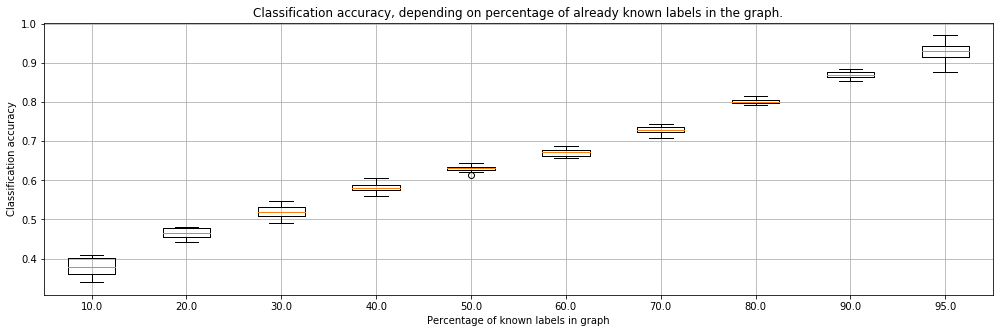

In [6]:
# Display as boxplot
plt.boxplot(pred_vec, labels = perc_vec*100)
plt.grid()
plt.title('Classification accuracy, depending on percentage of already known labels in the graph.')
plt.xlabel('Percentage of known labels in graph')
plt.ylabel('Classification accuracy')

For comparison:

Text(0,0.5,'Classification accuracy')

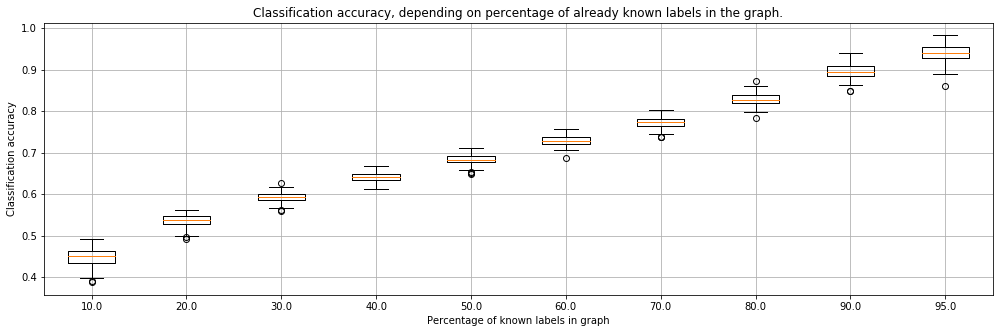

In [7]:
# Load file in same folder
pred_vec = np.load('semi-supervised_results/accuracy_cut_mfccs_raw_10_1028_5_Neigh200_Navg100.npy')
perc_vec = np.load('semi-supervised_results/percentage_cut_mfccs_raw_10_1028_5_Neigh200_Navg100.npy')

# Display as boxplot
plt.boxplot(pred_vec, labels = perc_vec*100)
plt.grid()
plt.title('Classification accuracy, depending on percentage of already known labels in the graph.')
plt.xlabel('Percentage of known labels in graph')
plt.ylabel('Classification accuracy')